In [1]:
import random
import math
import time
import pandas as pd
import numpy as np
import os
import os.path as osp
from PIL import Image

import torch.utils.data as data

rootpath = './PascalVOC/'

# パッケージのimport
import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [2]:
import glob

def image_list(path, train, validation):
    
    lis = glob.glob(rootpath+'JPEGImages/*.jpg')
    for i,l in enumerate(lis):
        lis[i] = l.split('/')[3][:-4]
    l_train = [l for i,l in enumerate(lis) if i%5!=0 ]
    l_val = [l for i,l in enumerate(lis) if i%5==0 ]
    print(l_train)
    print(l_val)
    
    if not osp.exists(rootpath+'ImageSets/Segmentation'):
        os.makedirs(rootpath+'ImageSets/Segmentation')
        
    with open(rootpath+'ImageSets/Segmentation/train.txt', mode='w') as f:
            f.write('\n'.join(l_train))
    with open(rootpath+'ImageSets/Segmentation/val.txt', mode='w') as f:
            f.write('\n'.join(l_val))    

image_list(rootpath, 7, 3)

['DJI_0174_5_3', 'DJI_0174_7_1', 'DJI_0174_5_1', 'DJI_0174_4_2', 'DJI_0174_4_3', 'DJI_0174_1_3', 'DJI_0174_2_1', 'DJI_0174_1_1', 'DJI_0174_4_1', 'DJI_0174_7_2', 'DJI_0174_3_3', 'DJI_0174_5_2', 'DJI_0174_6_1', 'DJI_0174_1_2']
['DJI_0174_2_2', 'DJI_0174_6_2', 'DJI_0174_3_2', 'DJI_0174_3_1']


In [3]:
from utils.dataloader import make_datapath_list, DataTransform, VOCDataset

# ファイルパスリスト作成
train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(
    rootpath=rootpath)

# Dataset作成
# (RGB)の色の平均値と標準偏差
color_mean = (0.485, 0.456, 0.406)
color_std = (0.229, 0.224, 0.225)

train_dataset = VOCDataset(train_img_list, train_anno_list, phase="train", transform=DataTransform(
    input_size=475, color_mean=color_mean, color_std=color_std))

val_dataset = VOCDataset(val_img_list, val_anno_list, phase="val", transform=DataTransform(
    input_size=475, color_mean=color_mean, color_std=color_std))

# DataLoader作成
batch_size = 8

train_dataloader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

# 辞書型変数にまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}


In [4]:
dataloaders_dict

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f2d1c4a6940>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7f2d1c4a66d8>}

In [5]:
def make_datapath_list(rootpath):
    # 画像ファイルとアノテーションファイルへのパスのテンプレートを作成
    imgpath_template = osp.join(rootpath, 'JPEGImages', '%s.jpg')
    annopath_template = osp.join(rootpath, 'SegmentationClassPNG', '%s.png')

    # 訓練と検証、それぞれのファイルのID（ファイル名）を取得する
    train_id_names = osp.join(rootpath + 'ImageSets/Segmentation/train.txt')
    val_id_names = osp.join(rootpath + 'ImageSets/Segmentation/val.txt')

    # 訓練データの画像ファイルとアノテーションファイルへのパスリストを作成
    train_img_list = list()
    train_anno_list = list()

    for line in open(train_id_names):
        file_id = line.strip()  # 空白スペースと改行を除去
        img_path = (imgpath_template % file_id)  # 画像のパス
        anno_path = (annopath_template % file_id)  # アノテーションのパス
        train_img_list.append(img_path)
        train_anno_list.append(anno_path)

    # 検証データの画像ファイルとアノテーションファイルへのパスリストを作成
    val_img_list = list()
    val_anno_list = list()

    for line in open(val_id_names):
        file_id = line.strip()  # 空白スペースと改行を除去
        img_path = (imgpath_template % file_id)  # 画像のパス
        anno_path = (annopath_template % file_id)  # アノテーションのパス
        val_img_list.append(img_path)
        val_anno_list.append(anno_path)

    return train_img_list, train_anno_list, val_img_list, val_anno_list


In [6]:
from utils.data_augumentation import Compose, Scale, RandomRotation, RandomMirror, Resize, Normalize_Tensor

In [7]:
class DataTransform():

    def __init__(self, input_size, color_mean, color_std):
        self.data_transform = {
            'train': Compose([
                Scale(scale=[0.5, 1.5]),  # 画像の拡大
                RandomRotation(angle=[-10, 10]),  # 回転
                RandomMirror(),  # ランダムミラー
                Resize(input_size),  # リサイズ(input_size)
                Normalize_Tensor(color_mean, color_std)  # 色情報の標準化とテンソル化
            ]),
            'val': Compose([
                Resize(input_size),  # リサイズ(input_size)
                Normalize_Tensor(color_mean, color_std)  # 色情報の標準化とテンソル化
            ])
        }

    def __call__(self, phase, img, anno_class_img):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            前処理のモードを指定。
        """
        return self.data_transform[phase](img, anno_class_img)


In [8]:
class VOCDataset(data.Dataset):

    def __init__(self, img_list, anno_list, phase, transform):
        self.img_list = img_list
        self.anno_list = anno_list
        self.phase = phase
        self.transform = transform

    def __len__(self):
        '''画像の枚数を返す'''
        return len(self.img_list)

    def __getitem__(self, index):
        '''
        前処理をした画像のTensor形式のデータとアノテーションを取得
        '''
        img, anno_class_img = self.pull_item(index)
        return img, anno_class_img

    def pull_item(self, index):
        '''画像のTensor形式のデータ、アノテーションを取得する'''

        # 1. 画像読み込み
        image_file_path = self.img_list[index]
        img = Image.open(image_file_path)   # [高さ][幅][色RGB]

        # 2. アノテーション画像読み込み
        anno_file_path = self.anno_list[index]
        anno_class_img = Image.open(anno_file_path)   # [高さ][幅]

        # 3. 前処理を実施
        img, anno_class_img = self.transform(self.phase, img, anno_class_img)

        return img, anno_class_img

In [9]:
# 動作確認

# (RGB)の色の平均値と標準偏差
color_mean = (0.485, 0.456, 0.406)
color_std = (0.229, 0.224, 0.225)

# データセット作成
train_dataset = VOCDataset(train_img_list, train_anno_list, phase="train", transform=DataTransform(
    input_size=475, color_mean=color_mean, color_std=color_std))

val_dataset = VOCDataset(val_img_list, val_anno_list, phase="val", transform=DataTransform(
    input_size=475, color_mean=color_mean, color_std=color_std))

# データの取り出し例
print(val_dataset.__getitem__(0)[0].shape)
print(val_dataset.__getitem__(0)[1].shape)
print(val_dataset.__getitem__(0))


torch.Size([3, 475, 475])
torch.Size([475, 475])
(tensor([[[ 0.5878,  0.5878,  0.5878,  ...,  0.4679,  0.4679,  0.4679],
         [ 0.5878,  0.5878,  0.5878,  ...,  0.4679,  0.4679,  0.4679],
         [ 0.5878,  0.5878,  0.5878,  ...,  0.4851,  0.4851,  0.4851],
         ...,
         [-1.1589, -1.1589, -1.1589,  ..., -0.3198, -0.3027, -0.3027],
         [-1.1589, -1.1589, -1.1589,  ..., -0.3369, -0.3198, -0.3198],
         [-1.1589, -1.1589, -1.1589,  ..., -0.3541, -0.3198, -0.3198]],

        [[ 0.1352,  0.1352,  0.1352,  ...,  0.0301,  0.0301,  0.0301],
         [ 0.1352,  0.1352,  0.1352,  ...,  0.0301,  0.0301,  0.0301],
         [ 0.1352,  0.1352,  0.1352,  ...,  0.0476,  0.0476,  0.0476],
         ...,
         [-0.3550, -0.3550, -0.3550,  ...,  0.3452,  0.3627,  0.3627],
         [-0.3550, -0.3550, -0.3550,  ...,  0.3277,  0.3452,  0.3452],
         [-0.3550, -0.3550, -0.3550,  ...,  0.3102,  0.3452,  0.3452]],

        [[-0.3055, -0.3055, -0.3055,  ..., -0.4973, -0.4973, -0.49

In [10]:
batch_size = 8

train_dataloader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

# 辞書オブジェクトにまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

# 動作の確認
batch_iterator = iter(dataloaders_dict["val"])  # イタレータに変換
imges, anno_class_imges = next(batch_iterator)  # 1番目の要素を取り出す
print(imges.size())  # torch.Size([8, 3, 475, 475])
print(anno_class_imges.size())  # torch.Size([8, 3, 475, 475])

torch.Size([4, 3, 475, 475])
torch.Size([4, 475, 475])


In [11]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


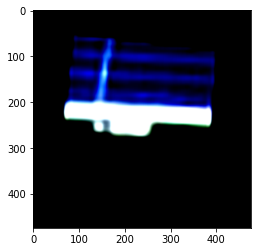

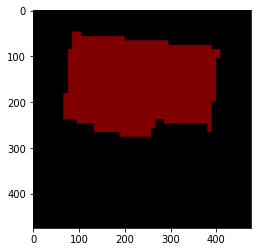

In [12]:
# 実行するたびに変わります

# 画像データの読み込み
index = 0
imges, anno_class_imges = train_dataset.__getitem__(index)

# 画像の表示
img_val = imges
img_val = img_val.numpy().transpose((1, 2, 0))
plt.imshow(img_val)
plt.show()

# アノテーション画像の表示
anno_file_path = train_anno_list[0]
anno_class_img = Image.open(anno_file_path)   # [高さ][幅][色RGB]
p_palette = anno_class_img.getpalette()

anno_class_img_val = anno_class_imges.numpy()
anno_class_img_val = Image.fromarray(np.uint8(anno_class_img_val), mode="P")
anno_class_img_val.putpalette(p_palette)
plt.imshow(anno_class_img_val)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


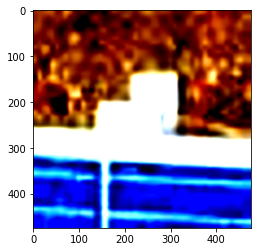

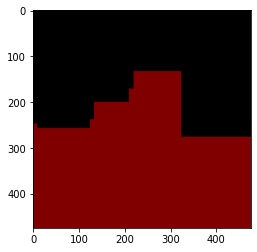

In [13]:
# 画像データの読み込み
index = 0
imges, anno_class_imges = val_dataset.__getitem__(index)

# 画像の表示
img_val = imges
img_val = img_val.numpy().transpose((1, 2, 0))
plt.imshow(img_val)
plt.show()

# アノテーション画像の表示
anno_file_path = train_anno_list[0]
anno_class_img = Image.open(anno_file_path)   # [高さ][幅][色RGB]
p_palette = anno_class_img.getpalette()

anno_class_img_val = anno_class_imges.numpy()
anno_class_img_val = Image.fromarray(np.uint8(anno_class_img_val), mode="P")
anno_class_img_val.putpalette(p_palette)
plt.imshow(anno_class_img_val)
plt.show()


PSP

In [14]:
class PSPNet(nn.Module):
    
    def __init__(self, n_classes):
        super(PSPNet, self).__init__()
        
        # パラメータ設定
        block_config = [3, 4, 6, 3]  # resnet50
        img_size = 475
        img_size_8 = 60  # img_sizeの1/8に
        
        # 4つのモジュールを構成するサブネットワークの用意
        self.feature_conv = FeatureMap_convolution()
        self.feature_res_1 = ResidualBlockPSP(
            n_blocks=block_config[0], in_channels=128, mid_channels=64, out_channels=256, stride=1, dilation=1)
        self.feature_res_2 = ResidualBlockPSP(
            n_blocks=block_config[1], in_channels=256, mid_channels=128, out_channels=512, stride=2, dilation=1)
        self.feature_dilated_res_1 = ResidualBlockPSP(
            n_blocks=block_config[2], in_channels=512, mid_channels=256, out_channels=1024, stride=1, dilation=2)
        self.feature_dilated_res_2 = ResidualBlockPSP(
            n_blocks=block_config[3], in_channels=1024, mid_channels=512, out_channels=2048, stride=1, dilation=4)

        self.pyramid_pooling = PyramidPooling(in_channels=2048, pool_sizes=[
            6, 3, 2, 1], height=img_size_8, width=img_size_8)

        self.decode_feature = DecodePSPFeature(
            height=img_size, width=img_size, n_classes=n_classes)

        self.aux = AuxiliaryPSPlayers(
            in_channels=1024, height=img_size, width=img_size, n_classes=n_classes)

    def forward(self, x):
        x = self.feature_conv(x)
        x = self.feature_res_1(x)
        x = self.feature_res_2(x)
        x = self.feature_dilated_res_1(x)

        output_aux = self.aux(x)  # Featureモジュールの途中をAuxモジュールへ

        x = self.feature_dilated_res_2(x)

        x = self.pyramid_pooling(x)
        output = self.decode_feature(x)

        return (output, output_aux)


In [15]:
class FeatureMap_convolution(nn.Module):
    def __init__(self):
        '''構成するネットワークを用意'''
        super(FeatureMap_convolution, self).__init__()

        # 畳み込み層1
        in_channels, out_channels, kernel_size, stride, padding, dilation, bias = 3, 64, 3, 2, 1, 1, False
        self.cbnr_1 = conv2DBatchNormRelu(
            in_channels, out_channels, kernel_size, stride, padding, dilation, bias)

        # 畳み込み層2
        in_channels, out_channels, kernel_size, stride, padding, dilation, bias = 64, 64, 3, 1, 1, 1, False
        self.cbnr_2 = conv2DBatchNormRelu(
            in_channels, out_channels, kernel_size, stride, padding, dilation, bias)

        # 畳み込み層3
        in_channels, out_channels, kernel_size, stride, padding, dilation, bias = 64, 128, 3, 1, 1, 1, False
        self.cbnr_3 = conv2DBatchNormRelu(
            in_channels, out_channels, kernel_size, stride, padding, dilation, bias)

        # MaxPooling層
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    def forward(self, x):
        x = self.cbnr_1(x)
        x = self.cbnr_2(x)
        x = self.cbnr_3(x)
        outputs = self.maxpool(x)
        return outputs


In [16]:
class ResidualBlockPSP(nn.Sequential):
    def __init__(self, n_blocks, in_channels, mid_channels, out_channels, stride, dilation):
        super(ResidualBlockPSP, self).__init__()

        # bottleNeckPSPの用意
        self.add_module(
            "block1",
            bottleNeckPSP(in_channels, mid_channels,
                          out_channels, stride, dilation)
        )

        # bottleNeckIdentifyPSPの繰り返しの用意
        for i in range(n_blocks - 1):
            self.add_module(
                "block" + str(i+2),
                bottleNeckIdentifyPSP(
                    out_channels, mid_channels, stride, dilation)
            )


In [17]:
class conv2DBatchNormRelu(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, dilation, bias):
        super(conv2DBatchNormRelu, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels,
                              kernel_size, stride, padding, dilation, bias=bias)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        # inplase設定で入力を保存せずに出力を計算し、メモリ削減する

    def forward(self, x):
        x = self.conv(x)
        x = self.batchnorm(x)
        outputs = self.relu(x)

        return outputs

In [18]:
class bottleNeckPSP(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels, stride, dilation):
        super(bottleNeckPSP, self).__init__()

        self.cbr_1 = conv2DBatchNormRelu(
            in_channels, mid_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)
        self.cbr_2 = conv2DBatchNormRelu(
            mid_channels, mid_channels, kernel_size=3, stride=stride, padding=dilation, dilation=dilation, bias=False)
        self.cb_3 = conv2DBatchNorm(
            mid_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)

        # スキップ結合
        self.cb_residual = conv2DBatchNorm(
            in_channels, out_channels, kernel_size=1, stride=stride, padding=0, dilation=1, bias=False)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        conv = self.cb_3(self.cbr_2(self.cbr_1(x)))
        residual = self.cb_residual(x)
        return self.relu(conv + residual)

In [19]:
class conv2DBatchNorm(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, dilation, bias):
        super(conv2DBatchNorm, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels,
                              kernel_size, stride, padding, dilation, bias=bias)
        self.batchnorm = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.conv(x)
        outputs = self.batchnorm(x)

        return outputs

In [20]:
class bottleNeckIdentifyPSP(nn.Module):
    def __init__(self, in_channels, mid_channels, stride, dilation):
        super(bottleNeckIdentifyPSP, self).__init__()

        self.cbr_1 = conv2DBatchNormRelu(
            in_channels, mid_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)
        self.cbr_2 = conv2DBatchNormRelu(
            mid_channels, mid_channels, kernel_size=3, stride=1, padding=dilation, dilation=dilation, bias=False)
        self.cb_3 = conv2DBatchNorm(
            mid_channels, in_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        conv = self.cb_3(self.cbr_2(self.cbr_1(x)))
        residual = x
        return self.relu(conv + residual)

Pyramid Polling

In [21]:
class PyramidPooling(nn.Module):
    def __init__(self, in_channels, pool_sizes, height, width):
        super(PyramidPooling, self).__init__()

        # forwardで使用する画像サイズ
        self.height = height
        self.width = width

        # 各畳み込み層の出力チャネル数
        out_channels = int(in_channels / len(pool_sizes))

        # 各畳み込み層を作成
        # この実装方法は愚直すぎてfor文で書きたいところですが、分かりやすさを優先しています
        # pool_sizes: [6, 3, 2, 1]
        self.avpool_1 = nn.AdaptiveAvgPool2d(output_size=pool_sizes[0])
        self.cbr_1 = conv2DBatchNormRelu(
            in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)

        self.avpool_2 = nn.AdaptiveAvgPool2d(output_size=pool_sizes[1])
        self.cbr_2 = conv2DBatchNormRelu(
            in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)

        self.avpool_3 = nn.AdaptiveAvgPool2d(output_size=pool_sizes[2])
        self.cbr_3 = conv2DBatchNormRelu(
            in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)

        self.avpool_4 = nn.AdaptiveAvgPool2d(output_size=pool_sizes[3])
        self.cbr_4 = conv2DBatchNormRelu(
            in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)

    def forward(self, x):

        out1 = self.cbr_1(self.avpool_1(x))
        out1 = F.interpolate(out1, size=(
            self.height, self.width), mode="bilinear", align_corners=True)

        out2 = self.cbr_2(self.avpool_2(x))
        out2 = F.interpolate(out2, size=(
            self.height, self.width), mode="bilinear", align_corners=True)

        out3 = self.cbr_3(self.avpool_3(x))
        out3 = F.interpolate(out3, size=(
            self.height, self.width), mode="bilinear", align_corners=True)

        out4 = self.cbr_4(self.avpool_4(x))
        out4 = F.interpolate(out4, size=(
            self.height, self.width), mode="bilinear", align_corners=True)

        # 最終的に結合させる、dim=1でチャネル数の次元で結合
        output = torch.cat([x, out1, out2, out3, out4], dim=1)

        return output

Decoder, AuxLoss

In [22]:
class DecodePSPFeature(nn.Module):
    def __init__(self, height, width, n_classes):
        super(DecodePSPFeature, self).__init__()

        # forwardで使用する画像サイズ
        self.height = height
        self.width = width

        self.cbr = conv2DBatchNormRelu(
            in_channels=4096, out_channels=512, kernel_size=3, stride=1, padding=1, dilation=1, bias=False)
        self.dropout = nn.Dropout2d(p=0.1)
        self.classification = nn.Conv2d(
            in_channels=512, out_channels=n_classes, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        x = self.cbr(x)
        x = self.dropout(x)
        x = self.classification(x)
        output = F.interpolate(
            x, size=(self.height, self.width), mode="bilinear", align_corners=True)

        return output


In [23]:
class AuxiliaryPSPlayers(nn.Module):
    def __init__(self, in_channels, height, width, n_classes):
        super(AuxiliaryPSPlayers, self).__init__()

        # forwardで使用する画像サイズ
        self.height = height
        self.width = width

        self.cbr = conv2DBatchNormRelu(
            in_channels=in_channels, out_channels=256, kernel_size=3, stride=1, padding=1, dilation=1, bias=False)
        self.dropout = nn.Dropout2d(p=0.1)
        self.classification = nn.Conv2d(
            in_channels=256, out_channels=n_classes, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        x = self.cbr(x)
        x = self.dropout(x)
        x = self.classification(x)
        output = F.interpolate(
            x, size=(self.height, self.width), mode="bilinear", align_corners=True)

        return output

In [25]:
net = PSPNet(n_classes=2)

# ADE20K学習済みパラメータをロード
state_dict = torch.load("./weights/vgg16_reducedfc.pth")
net.load_state_dict(state_dict)


# 分類用の畳み込み層を、出力数21のものにつけかえる
n_classes = 2
net.decode_feature.classification = nn.Conv2d(
    in_channels=512, out_channels=n_classes, kernel_size=1, stride=1, padding=0)

net.aux.classification = nn.Conv2d(
    in_channels=256, out_channels=n_classes, kernel_size=1, stride=1, padding=0)

def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_normal_(m.weight.data)
        if m.bias is not None:  # バイアス項がある場合
            nn.init.constant_(m.bias, 0.0)

net.decode_feature.classification.apply(weights_init)
net.aux.classification.apply(weights_init)


print('ネットワーク設定完了：学習済みの重みをロードしました')

RuntimeError: Error(s) in loading state_dict for PSPNet:
	Missing key(s) in state_dict: "feature_conv.cbnr_1.conv.weight", "feature_conv.cbnr_1.batchnorm.weight", "feature_conv.cbnr_1.batchnorm.bias", "feature_conv.cbnr_1.batchnorm.running_mean", "feature_conv.cbnr_1.batchnorm.running_var", "feature_conv.cbnr_2.conv.weight", "feature_conv.cbnr_2.batchnorm.weight", "feature_conv.cbnr_2.batchnorm.bias", "feature_conv.cbnr_2.batchnorm.running_mean", "feature_conv.cbnr_2.batchnorm.running_var", "feature_conv.cbnr_3.conv.weight", "feature_conv.cbnr_3.batchnorm.weight", "feature_conv.cbnr_3.batchnorm.bias", "feature_conv.cbnr_3.batchnorm.running_mean", "feature_conv.cbnr_3.batchnorm.running_var", "feature_res_1.block1.cbr_1.conv.weight", "feature_res_1.block1.cbr_1.batchnorm.weight", "feature_res_1.block1.cbr_1.batchnorm.bias", "feature_res_1.block1.cbr_1.batchnorm.running_mean", "feature_res_1.block1.cbr_1.batchnorm.running_var", "feature_res_1.block1.cbr_2.conv.weight", "feature_res_1.block1.cbr_2.batchnorm.weight", "feature_res_1.block1.cbr_2.batchnorm.bias", "feature_res_1.block1.cbr_2.batchnorm.running_mean", "feature_res_1.block1.cbr_2.batchnorm.running_var", "feature_res_1.block1.cb_3.conv.weight", "feature_res_1.block1.cb_3.batchnorm.weight", "feature_res_1.block1.cb_3.batchnorm.bias", "feature_res_1.block1.cb_3.batchnorm.running_mean", "feature_res_1.block1.cb_3.batchnorm.running_var", "feature_res_1.block1.cb_residual.conv.weight", "feature_res_1.block1.cb_residual.batchnorm.weight", "feature_res_1.block1.cb_residual.batchnorm.bias", "feature_res_1.block1.cb_residual.batchnorm.running_mean", "feature_res_1.block1.cb_residual.batchnorm.running_var", "feature_res_1.block2.cbr_1.conv.weight", "feature_res_1.block2.cbr_1.batchnorm.weight", "feature_res_1.block2.cbr_1.batchnorm.bias", "feature_res_1.block2.cbr_1.batchnorm.running_mean", "feature_res_1.block2.cbr_1.batchnorm.running_var", "feature_res_1.block2.cbr_2.conv.weight", "feature_res_1.block2.cbr_2.batchnorm.weight", "feature_res_1.block2.cbr_2.batchnorm.bias", "feature_res_1.block2.cbr_2.batchnorm.running_mean", "feature_res_1.block2.cbr_2.batchnorm.running_var", "feature_res_1.block2.cb_3.conv.weight", "feature_res_1.block2.cb_3.batchnorm.weight", "feature_res_1.block2.cb_3.batchnorm.bias", "feature_res_1.block2.cb_3.batchnorm.running_mean", "feature_res_1.block2.cb_3.batchnorm.running_var", "feature_res_1.block3.cbr_1.conv.weight", "feature_res_1.block3.cbr_1.batchnorm.weight", "feature_res_1.block3.cbr_1.batchnorm.bias", "feature_res_1.block3.cbr_1.batchnorm.running_mean", "feature_res_1.block3.cbr_1.batchnorm.running_var", "feature_res_1.block3.cbr_2.conv.weight", "feature_res_1.block3.cbr_2.batchnorm.weight", "feature_res_1.block3.cbr_2.batchnorm.bias", "feature_res_1.block3.cbr_2.batchnorm.running_mean", "feature_res_1.block3.cbr_2.batchnorm.running_var", "feature_res_1.block3.cb_3.conv.weight", "feature_res_1.block3.cb_3.batchnorm.weight", "feature_res_1.block3.cb_3.batchnorm.bias", "feature_res_1.block3.cb_3.batchnorm.running_mean", "feature_res_1.block3.cb_3.batchnorm.running_var", "feature_res_2.block1.cbr_1.conv.weight", "feature_res_2.block1.cbr_1.batchnorm.weight", "feature_res_2.block1.cbr_1.batchnorm.bias", "feature_res_2.block1.cbr_1.batchnorm.running_mean", "feature_res_2.block1.cbr_1.batchnorm.running_var", "feature_res_2.block1.cbr_2.conv.weight", "feature_res_2.block1.cbr_2.batchnorm.weight", "feature_res_2.block1.cbr_2.batchnorm.bias", "feature_res_2.block1.cbr_2.batchnorm.running_mean", "feature_res_2.block1.cbr_2.batchnorm.running_var", "feature_res_2.block1.cb_3.conv.weight", "feature_res_2.block1.cb_3.batchnorm.weight", "feature_res_2.block1.cb_3.batchnorm.bias", "feature_res_2.block1.cb_3.batchnorm.running_mean", "feature_res_2.block1.cb_3.batchnorm.running_var", "feature_res_2.block1.cb_residual.conv.weight", "feature_res_2.block1.cb_residual.batchnorm.weight", "feature_res_2.block1.cb_residual.batchnorm.bias", "feature_res_2.block1.cb_residual.batchnorm.running_mean", "feature_res_2.block1.cb_residual.batchnorm.running_var", "feature_res_2.block2.cbr_1.conv.weight", "feature_res_2.block2.cbr_1.batchnorm.weight", "feature_res_2.block2.cbr_1.batchnorm.bias", "feature_res_2.block2.cbr_1.batchnorm.running_mean", "feature_res_2.block2.cbr_1.batchnorm.running_var", "feature_res_2.block2.cbr_2.conv.weight", "feature_res_2.block2.cbr_2.batchnorm.weight", "feature_res_2.block2.cbr_2.batchnorm.bias", "feature_res_2.block2.cbr_2.batchnorm.running_mean", "feature_res_2.block2.cbr_2.batchnorm.running_var", "feature_res_2.block2.cb_3.conv.weight", "feature_res_2.block2.cb_3.batchnorm.weight", "feature_res_2.block2.cb_3.batchnorm.bias", "feature_res_2.block2.cb_3.batchnorm.running_mean", "feature_res_2.block2.cb_3.batchnorm.running_var", "feature_res_2.block3.cbr_1.conv.weight", "feature_res_2.block3.cbr_1.batchnorm.weight", "feature_res_2.block3.cbr_1.batchnorm.bias", "feature_res_2.block3.cbr_1.batchnorm.running_mean", "feature_res_2.block3.cbr_1.batchnorm.running_var", "feature_res_2.block3.cbr_2.conv.weight", "feature_res_2.block3.cbr_2.batchnorm.weight", "feature_res_2.block3.cbr_2.batchnorm.bias", "feature_res_2.block3.cbr_2.batchnorm.running_mean", "feature_res_2.block3.cbr_2.batchnorm.running_var", "feature_res_2.block3.cb_3.conv.weight", "feature_res_2.block3.cb_3.batchnorm.weight", "feature_res_2.block3.cb_3.batchnorm.bias", "feature_res_2.block3.cb_3.batchnorm.running_mean", "feature_res_2.block3.cb_3.batchnorm.running_var", "feature_res_2.block4.cbr_1.conv.weight", "feature_res_2.block4.cbr_1.batchnorm.weight", "feature_res_2.block4.cbr_1.batchnorm.bias", "feature_res_2.block4.cbr_1.batchnorm.running_mean", "feature_res_2.block4.cbr_1.batchnorm.running_var", "feature_res_2.block4.cbr_2.conv.weight", "feature_res_2.block4.cbr_2.batchnorm.weight", "feature_res_2.block4.cbr_2.batchnorm.bias", "feature_res_2.block4.cbr_2.batchnorm.running_mean", "feature_res_2.block4.cbr_2.batchnorm.running_var", "feature_res_2.block4.cb_3.conv.weight", "feature_res_2.block4.cb_3.batchnorm.weight", "feature_res_2.block4.cb_3.batchnorm.bias", "feature_res_2.block4.cb_3.batchnorm.running_mean", "feature_res_2.block4.cb_3.batchnorm.running_var", "feature_dilated_res_1.block1.cbr_1.conv.weight", "feature_dilated_res_1.block1.cbr_1.batchnorm.weight", "feature_dilated_res_1.block1.cbr_1.batchnorm.bias", "feature_dilated_res_1.block1.cbr_1.batchnorm.running_mean", "feature_dilated_res_1.block1.cbr_1.batchnorm.running_var", "feature_dilated_res_1.block1.cbr_2.conv.weight", "feature_dilated_res_1.block1.cbr_2.batchnorm.weight", "feature_dilated_res_1.block1.cbr_2.batchnorm.bias", "feature_dilated_res_1.block1.cbr_2.batchnorm.running_mean", "feature_dilated_res_1.block1.cbr_2.batchnorm.running_var", "feature_dilated_res_1.block1.cb_3.conv.weight", "feature_dilated_res_1.block1.cb_3.batchnorm.weight", "feature_dilated_res_1.block1.cb_3.batchnorm.bias", "feature_dilated_res_1.block1.cb_3.batchnorm.running_mean", "feature_dilated_res_1.block1.cb_3.batchnorm.running_var", "feature_dilated_res_1.block1.cb_residual.conv.weight", "feature_dilated_res_1.block1.cb_residual.batchnorm.weight", "feature_dilated_res_1.block1.cb_residual.batchnorm.bias", "feature_dilated_res_1.block1.cb_residual.batchnorm.running_mean", "feature_dilated_res_1.block1.cb_residual.batchnorm.running_var", "feature_dilated_res_1.block2.cbr_1.conv.weight", "feature_dilated_res_1.block2.cbr_1.batchnorm.weight", "feature_dilated_res_1.block2.cbr_1.batchnorm.bias", "feature_dilated_res_1.block2.cbr_1.batchnorm.running_mean", "feature_dilated_res_1.block2.cbr_1.batchnorm.running_var", "feature_dilated_res_1.block2.cbr_2.conv.weight", "feature_dilated_res_1.block2.cbr_2.batchnorm.weight", "feature_dilated_res_1.block2.cbr_2.batchnorm.bias", "feature_dilated_res_1.block2.cbr_2.batchnorm.running_mean", "feature_dilated_res_1.block2.cbr_2.batchnorm.running_var", "feature_dilated_res_1.block2.cb_3.conv.weight", "feature_dilated_res_1.block2.cb_3.batchnorm.weight", "feature_dilated_res_1.block2.cb_3.batchnorm.bias", "feature_dilated_res_1.block2.cb_3.batchnorm.running_mean", "feature_dilated_res_1.block2.cb_3.batchnorm.running_var", "feature_dilated_res_1.block3.cbr_1.conv.weight", "feature_dilated_res_1.block3.cbr_1.batchnorm.weight", "feature_dilated_res_1.block3.cbr_1.batchnorm.bias", "feature_dilated_res_1.block3.cbr_1.batchnorm.running_mean", "feature_dilated_res_1.block3.cbr_1.batchnorm.running_var", "feature_dilated_res_1.block3.cbr_2.conv.weight", "feature_dilated_res_1.block3.cbr_2.batchnorm.weight", "feature_dilated_res_1.block3.cbr_2.batchnorm.bias", "feature_dilated_res_1.block3.cbr_2.batchnorm.running_mean", "feature_dilated_res_1.block3.cbr_2.batchnorm.running_var", "feature_dilated_res_1.block3.cb_3.conv.weight", "feature_dilated_res_1.block3.cb_3.batchnorm.weight", "feature_dilated_res_1.block3.cb_3.batchnorm.bias", "feature_dilated_res_1.block3.cb_3.batchnorm.running_mean", "feature_dilated_res_1.block3.cb_3.batchnorm.running_var", "feature_dilated_res_1.block4.cbr_1.conv.weight", "feature_dilated_res_1.block4.cbr_1.batchnorm.weight", "feature_dilated_res_1.block4.cbr_1.batchnorm.bias", "feature_dilated_res_1.block4.cbr_1.batchnorm.running_mean", "feature_dilated_res_1.block4.cbr_1.batchnorm.running_var", "feature_dilated_res_1.block4.cbr_2.conv.weight", "feature_dilated_res_1.block4.cbr_2.batchnorm.weight", "feature_dilated_res_1.block4.cbr_2.batchnorm.bias", "feature_dilated_res_1.block4.cbr_2.batchnorm.running_mean", "feature_dilated_res_1.block4.cbr_2.batchnorm.running_var", "feature_dilated_res_1.block4.cb_3.conv.weight", "feature_dilated_res_1.block4.cb_3.batchnorm.weight", "feature_dilated_res_1.block4.cb_3.batchnorm.bias", "feature_dilated_res_1.block4.cb_3.batchnorm.running_mean", "feature_dilated_res_1.block4.cb_3.batchnorm.running_var", "feature_dilated_res_1.block5.cbr_1.conv.weight", "feature_dilated_res_1.block5.cbr_1.batchnorm.weight", "feature_dilated_res_1.block5.cbr_1.batchnorm.bias", "feature_dilated_res_1.block5.cbr_1.batchnorm.running_mean", "feature_dilated_res_1.block5.cbr_1.batchnorm.running_var", "feature_dilated_res_1.block5.cbr_2.conv.weight", "feature_dilated_res_1.block5.cbr_2.batchnorm.weight", "feature_dilated_res_1.block5.cbr_2.batchnorm.bias", "feature_dilated_res_1.block5.cbr_2.batchnorm.running_mean", "feature_dilated_res_1.block5.cbr_2.batchnorm.running_var", "feature_dilated_res_1.block5.cb_3.conv.weight", "feature_dilated_res_1.block5.cb_3.batchnorm.weight", "feature_dilated_res_1.block5.cb_3.batchnorm.bias", "feature_dilated_res_1.block5.cb_3.batchnorm.running_mean", "feature_dilated_res_1.block5.cb_3.batchnorm.running_var", "feature_dilated_res_1.block6.cbr_1.conv.weight", "feature_dilated_res_1.block6.cbr_1.batchnorm.weight", "feature_dilated_res_1.block6.cbr_1.batchnorm.bias", "feature_dilated_res_1.block6.cbr_1.batchnorm.running_mean", "feature_dilated_res_1.block6.cbr_1.batchnorm.running_var", "feature_dilated_res_1.block6.cbr_2.conv.weight", "feature_dilated_res_1.block6.cbr_2.batchnorm.weight", "feature_dilated_res_1.block6.cbr_2.batchnorm.bias", "feature_dilated_res_1.block6.cbr_2.batchnorm.running_mean", "feature_dilated_res_1.block6.cbr_2.batchnorm.running_var", "feature_dilated_res_1.block6.cb_3.conv.weight", "feature_dilated_res_1.block6.cb_3.batchnorm.weight", "feature_dilated_res_1.block6.cb_3.batchnorm.bias", "feature_dilated_res_1.block6.cb_3.batchnorm.running_mean", "feature_dilated_res_1.block6.cb_3.batchnorm.running_var", "feature_dilated_res_2.block1.cbr_1.conv.weight", "feature_dilated_res_2.block1.cbr_1.batchnorm.weight", "feature_dilated_res_2.block1.cbr_1.batchnorm.bias", "feature_dilated_res_2.block1.cbr_1.batchnorm.running_mean", "feature_dilated_res_2.block1.cbr_1.batchnorm.running_var", "feature_dilated_res_2.block1.cbr_2.conv.weight", "feature_dilated_res_2.block1.cbr_2.batchnorm.weight", "feature_dilated_res_2.block1.cbr_2.batchnorm.bias", "feature_dilated_res_2.block1.cbr_2.batchnorm.running_mean", "feature_dilated_res_2.block1.cbr_2.batchnorm.running_var", "feature_dilated_res_2.block1.cb_3.conv.weight", "feature_dilated_res_2.block1.cb_3.batchnorm.weight", "feature_dilated_res_2.block1.cb_3.batchnorm.bias", "feature_dilated_res_2.block1.cb_3.batchnorm.running_mean", "feature_dilated_res_2.block1.cb_3.batchnorm.running_var", "feature_dilated_res_2.block1.cb_residual.conv.weight", "feature_dilated_res_2.block1.cb_residual.batchnorm.weight", "feature_dilated_res_2.block1.cb_residual.batchnorm.bias", "feature_dilated_res_2.block1.cb_residual.batchnorm.running_mean", "feature_dilated_res_2.block1.cb_residual.batchnorm.running_var", "feature_dilated_res_2.block2.cbr_1.conv.weight", "feature_dilated_res_2.block2.cbr_1.batchnorm.weight", "feature_dilated_res_2.block2.cbr_1.batchnorm.bias", "feature_dilated_res_2.block2.cbr_1.batchnorm.running_mean", "feature_dilated_res_2.block2.cbr_1.batchnorm.running_var", "feature_dilated_res_2.block2.cbr_2.conv.weight", "feature_dilated_res_2.block2.cbr_2.batchnorm.weight", "feature_dilated_res_2.block2.cbr_2.batchnorm.bias", "feature_dilated_res_2.block2.cbr_2.batchnorm.running_mean", "feature_dilated_res_2.block2.cbr_2.batchnorm.running_var", "feature_dilated_res_2.block2.cb_3.conv.weight", "feature_dilated_res_2.block2.cb_3.batchnorm.weight", "feature_dilated_res_2.block2.cb_3.batchnorm.bias", "feature_dilated_res_2.block2.cb_3.batchnorm.running_mean", "feature_dilated_res_2.block2.cb_3.batchnorm.running_var", "feature_dilated_res_2.block3.cbr_1.conv.weight", "feature_dilated_res_2.block3.cbr_1.batchnorm.weight", "feature_dilated_res_2.block3.cbr_1.batchnorm.bias", "feature_dilated_res_2.block3.cbr_1.batchnorm.running_mean", "feature_dilated_res_2.block3.cbr_1.batchnorm.running_var", "feature_dilated_res_2.block3.cbr_2.conv.weight", "feature_dilated_res_2.block3.cbr_2.batchnorm.weight", "feature_dilated_res_2.block3.cbr_2.batchnorm.bias", "feature_dilated_res_2.block3.cbr_2.batchnorm.running_mean", "feature_dilated_res_2.block3.cbr_2.batchnorm.running_var", "feature_dilated_res_2.block3.cb_3.conv.weight", "feature_dilated_res_2.block3.cb_3.batchnorm.weight", "feature_dilated_res_2.block3.cb_3.batchnorm.bias", "feature_dilated_res_2.block3.cb_3.batchnorm.running_mean", "feature_dilated_res_2.block3.cb_3.batchnorm.running_var", "pyramid_pooling.cbr_1.conv.weight", "pyramid_pooling.cbr_1.batchnorm.weight", "pyramid_pooling.cbr_1.batchnorm.bias", "pyramid_pooling.cbr_1.batchnorm.running_mean", "pyramid_pooling.cbr_1.batchnorm.running_var", "pyramid_pooling.cbr_2.conv.weight", "pyramid_pooling.cbr_2.batchnorm.weight", "pyramid_pooling.cbr_2.batchnorm.bias", "pyramid_pooling.cbr_2.batchnorm.running_mean", "pyramid_pooling.cbr_2.batchnorm.running_var", "pyramid_pooling.cbr_3.conv.weight", "pyramid_pooling.cbr_3.batchnorm.weight", "pyramid_pooling.cbr_3.batchnorm.bias", "pyramid_pooling.cbr_3.batchnorm.running_mean", "pyramid_pooling.cbr_3.batchnorm.running_var", "pyramid_pooling.cbr_4.conv.weight", "pyramid_pooling.cbr_4.batchnorm.weight", "pyramid_pooling.cbr_4.batchnorm.bias", "pyramid_pooling.cbr_4.batchnorm.running_mean", "pyramid_pooling.cbr_4.batchnorm.running_var", "decode_feature.cbr.conv.weight", "decode_feature.cbr.batchnorm.weight", "decode_feature.cbr.batchnorm.bias", "decode_feature.cbr.batchnorm.running_mean", "decode_feature.cbr.batchnorm.running_var", "decode_feature.classification.weight", "decode_feature.classification.bias", "aux.cbr.conv.weight", "aux.cbr.batchnorm.weight", "aux.cbr.batchnorm.bias", "aux.cbr.batchnorm.running_mean", "aux.cbr.batchnorm.running_var", "aux.classification.weight", "aux.classification.bias". 
	Unexpected key(s) in state_dict: "0.weight", "0.bias", "2.weight", "2.bias", "5.weight", "5.bias", "7.weight", "7.bias", "10.weight", "10.bias", "12.weight", "12.bias", "14.weight", "14.bias", "17.weight", "17.bias", "19.weight", "19.bias", "21.weight", "21.bias", "24.weight", "24.bias", "26.weight", "26.bias", "28.weight", "28.bias", "31.weight", "31.bias", "33.weight", "33.bias". 

In [ ]:
net


損失関数

In [109]:
class PSPLoss(nn.Module):
    """PSPNetの損失関数のクラスです。"""

    def __init__(self, aux_weight=0.4):
        super(PSPLoss, self).__init__()
        self.aux_weight = aux_weight  # aux_lossの重み

    def forward(self, outputs, targets):
        """
        損失関数の計算。

        Parameters
        ----------
        outputs : PSPNetの出力(tuple)
            (output=torch.Size([num_batch, 21, 475, 475]), output_aux=torch.Size([num_batch, 21, 475, 475]))。

        targets : [num_batch, 475, 4755]
            正解のアノテーション情報

        Returns
        -------
        loss : テンソル
            損失の値
        """

        loss = F.cross_entropy(outputs[0], targets, reduction='mean')
        loss_aux = F.cross_entropy(outputs[1], targets, reduction='mean')

        return loss+self.aux_weight*loss_aux


criterion = PSPLoss(aux_weight=0.4)

最適化手法

In [110]:
# ファインチューニングなので、学習率は小さく
optimizer = optim.SGD([
    {'params': net.feature_conv.parameters(), 'lr': 1e-3},
    {'params': net.feature_res_1.parameters(), 'lr': 1e-3},
    {'params': net.feature_res_2.parameters(), 'lr': 1e-3},
    {'params': net.feature_dilated_res_1.parameters(), 'lr': 1e-3},
    {'params': net.feature_dilated_res_2.parameters(), 'lr': 1e-3},
    {'params': net.pyramid_pooling.parameters(), 'lr': 1e-3},
    {'params': net.decode_feature.parameters(), 'lr': 1e-2},
    {'params': net.aux.parameters(), 'lr': 1e-2},
], momentum=0.9, weight_decay=0.0001)


# スケジューラーの設定
def lambda_epoch(epoch):
    max_epoch = 30
    return math.pow((1-epoch/max_epoch), 0.9)


scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_epoch)

学習

In [111]:
# モデルを学習させる関数を作成


def train_model(net, dataloaders_dict, criterion, scheduler, optimizer, num_epochs):

    # GPUが使えるかを確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス：", device)

    # ネットワークをGPUへ
    net.to(device)

    # ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True

    # 画像の枚数
    num_train_imgs = len(dataloaders_dict["train"].dataset)
    num_val_imgs = len(dataloaders_dict["val"].dataset)
    batch_size = dataloaders_dict["train"].batch_size

    # イテレーションカウンタをセット
    iteration = 1
    logs = []

    # multiple minibatch
    batch_multiplier = 3

    # epochのループ
    for epoch in range(num_epochs):

        # 開始時刻を保存
        t_epoch_start = time.time()
        t_iter_start = time.time()
        epoch_train_loss = 0.0  # epochの損失和
        epoch_val_loss = 0.0  # epochの損失和

        print('-------------')
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        # epochごとの訓練と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # モデルを訓練モードに
                scheduler.step()  # 最適化schedulerの更新
                optimizer.zero_grad()
                print('（train）')

            else:
                if((epoch+1) % 5 == 0):
                    net.eval()   # モデルを検証モードに
                    print('-------------')
                    print('（val）')
                else:
                    # 検証は5回に1回だけ行う
                    continue

            # データローダーからminibatchずつ取り出すループ
            count = 0  # multiple minibatch
            for imges, anno_class_imges in dataloaders_dict[phase]:
                # ミニバッチがサイズが1だと、バッチノーマライゼーションでエラーになるのでさける
                if imges.size()[0] == 1:
                    continue

                # GPUが使えるならGPUにデータを送る
                imges = imges.to(device)
                anno_class_imges = anno_class_imges.to(device)

                
                # multiple minibatchでのパラメータの更新
                if (phase == 'train') and (count == 0):
                    optimizer.step()
                    optimizer.zero_grad()
                    count = batch_multiplier

                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(imges)
                    loss = criterion(
                        outputs, anno_class_imges.long()) / batch_multiplier

                    # 訓練時はバックプロパゲーション
                    if phase == 'train':
                        loss.backward()  # 勾配の計算
                        count -= 1  # multiple minibatch

                        if (iteration % 10 == 0):  # 10iterに1度、lossを表示
                            t_iter_finish = time.time()
                            duration = t_iter_finish - t_iter_start
                            print('イテレーション {} || Loss: {:.4f} || 10iter: {:.4f} sec.'.format(
                                iteration, loss.item()/batch_size*batch_multiplier, duration))
                            t_iter_start = time.time()

                        epoch_train_loss += loss.item() * batch_multiplier
                        iteration += 1

                    # 検証時
                    else:
                        epoch_val_loss += loss.item() * batch_multiplier

        # epochのphaseごとのlossと正解率
        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Epoch_TRAIN_Loss:{:.4f} ||Epoch_VAL_Loss:{:.4f}'.format(
            epoch+1, epoch_train_loss/num_train_imgs, epoch_val_loss/num_val_imgs))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()

        # ログを保存
        log_epoch = {'epoch': epoch+1, 'train_loss': epoch_train_loss /
                     num_train_imgs, 'val_loss': epoch_val_loss/num_val_imgs}
        logs.append(log_epoch)
        df = pd.DataFrame(logs)
        df.to_csv("log_output.csv")

    # 最後のネットワークを保存する
    torch.save(net.state_dict(), 'pspnet50_' +str(epoch+1) + '.pth')


In [112]:
# 学習・検証を実行する
num_epochs = 30
train_model(net, dataloaders_dict, criterion, scheduler, optimizer, num_epochs=num_epochs)


使用デバイス： cuda:0
-------------
Epoch 1/30
-------------
（train）
-------------
epoch 1 || Epoch_TRAIN_Loss:0.1483 ||Epoch_VAL_Loss:0.0000
timer:  2.4145 sec.
-------------
Epoch 2/30
-------------
（train）


RuntimeError: CUDA out of memory. Tried to allocate 450.00 MiB (GPU 0; 10.91 GiB total capacity; 9.15 GiB already allocated; 46.38 MiB free; 9.89 GiB reserved in total by PyTorch)